In [24]:
import numpy as np
import pandas as pd
from make_cache import main, decryption
num_threads = 8
max_n_plus = 5
clear_mem = False
seed = np.random.randint(10000)
# seed = 2062
# seed = 1986
# seed = 9852
for n_plus in range(1, max_n_plus + 1):
    main(n_plus,num_threads,len_x=40, log_interval=3, seed=seed, clear_mem=clear_mem)

2025-05-16 14:17:26,346 : numba=0.61.2, numpy=2.2.4
2025-05-16 14:17:26,346 : OPT=_OptLevel(3), THREADING_LAYER=default
2025-05-16 14:17:26,346 : USING_SVML=False, ENABLE_AVX=True, DISABLE_JIT=0
2025-05-16 14:17:26,346 : max_op = 1  ,  date : 2025-05-16 14:17:26.346946
2025-05-16 14:17:26,347 : use cores : 8
2025-05-16 14:17:26,347 : making random_x
2025-05-16 14:17:26,347 :    seed = 966, loop = 100000, upper = 0.5, lower = 1.5
2025-05-16 14:17:26,690 : random_x corrcoef = 2.5018834937742225e-07
2025-05-16 14:17:26,892 : make_before_similar_num_list
2025-05-16 14:17:26,892 :    using Memory size =  194.5 MB
2025-05-16 14:17:26,892 :    Memory size of numpy array = 0.0 M bytes +alpha (1data=1280 bytes, loop=2)
2025-05-16 14:17:29,956 :    time : 0:00:03.063529
2025-05-16 14:17:29,956 : make_unique_equations
2025-05-16 14:17:29,957 :    n_op1 = 0, n_op2 = 0
2025-05-16 14:17:31,518 :       make_unique_equations_thread
2025-05-16 14:17:31,518 :          using Memory size =  244.8 MB
2025-

6:4   
51:29   
630:281   
10208:3263   
201551:50154   
[2, 10, 80, 911, 13471, 251705, 5561536]   

In [ ]:
#np.save("arr_len", np.array([2],dtype="int64"))
#np.save("operator_0",np.array([[1],[0]],dtype="int8"))
#np.savez(f"check_change_x_tot_0", np.full((2, 2, 2), -100, dtype="int8"))

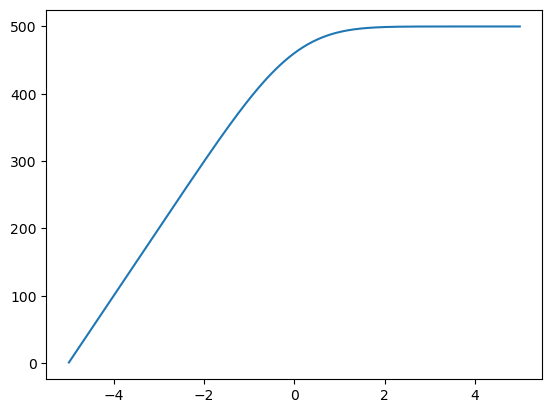

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
base_T = 0
def f2(mu):
    f = lambda x: (np.exp(-(x - mu)**2/2)) / np.sqrt(2*np.pi)
    return integrate.quad(f, mu - 5, 0)[0]
arr_T = np.linspace(base_T - 5.0, base_T + 5.0, 1000)
N = [f2(mu) for mu in arr_T]

plt.plot(arr_T, np.cumsum(N))

In [14]:
import numpy as np
import itertools as iter
r_x = np.random.random(5)
for i in iter.permutations([0,1,2,3,4]):
    if i[0] < i[1] and i[2] < i[3] and i[0] < i[2] and i[1] < i[3]:
        num = ((r_x[i[0]] * r_x[i[1]]) + (r_x[i[2]] * r_x[i[3]]))
        num += ((r_x[i[1]] * r_x[i[3]]) + (r_x[i[2]] * r_x[i[4]]))
        num /= r_x[i[2]]
        print(i, i[2], num)

(0, 1, 2, 3, 4) 2 27.241269439861554
(0, 1, 2, 4, 3) 2 10.724667872197235
(0, 1, 3, 4, 2) 3 0.42739803452015795
(0, 2, 1, 3, 4) 1 0.9193091512190226
(0, 2, 1, 4, 3) 1 0.8854398582638005
(0, 2, 3, 4, 1) 3 0.689877413659238
(0, 3, 1, 4, 2) 1 0.6713242895130479
(0, 3, 2, 4, 1) 2 13.58844200753505
(1, 2, 3, 4, 0) 3 0.4697903603557153
(1, 3, 2, 4, 0) 2 19.954345637740964


In [5]:
from numba import njit, prange, set_num_threads, objmode, get_num_threads

from utils_for_make_cache import *

def sub_check_exist_step3_last(
    max_op,
    num_threads,
    random_x,
    check_exist_eq,
    dict_mask_x,
    indexes,
):
    # max_op = 7
    print_counter = 0
    lim_print_counter = 100000000
    printed = False

    int_nan = -100
    arange = np.arange(indexes.shape[0])
    equation = check_exist_eq[indexes[0]]
    eq_x_max = np.max(equation)
    mask_x = dict_mask_x[eq_x_max]
    mat_use = np.empty((num_threads, indexes.shape[0], 3), dtype="int64")
    return_mat_use = np.full((indexes.shape[0], 2), int_nan, dtype="int64")
    norm_cache_for_mask_x = np.zeros((mask_x.shape[0], random_x.shape[1]), dtype="float64")
    TF_mask_x = np.ones((indexes.shape[0], mask_x.shape[0]), dtype="bool")
    norm_same_for_mask_x = np.zeros((mask_x.shape[0]), dtype="int64")
    dict_check_change_x = dict()
    norm_n = 0
    for k in range(mask_x.shape[0]):
        similar_num = nb_calc_RPN(random_x[mask_x[k]], equation)[0]
        norm_same = False
        for l in range(norm_n):
            if isclose(norm_cache_for_mask_x[l, 0], similar_num[0]):
                if isclose_arr(norm_cache_for_mask_x[l], similar_num):
                    norm_same = True
                    break
        if not norm_same:
            norm_cache_for_mask_x[norm_n] = similar_num
            norm_n += 1
    norm_cache_for_mask_x = norm_cache_for_mask_x[:norm_n]
    len_norm_cache_for_mask_x = norm_n

    same_norm_num_index = np.empty((indexes.shape[0], mask_x.shape[0]), dtype="int64")
    patterns = np.empty((indexes.shape[0]), dtype="int64")
    use = np.full((indexes.shape[0]), int_nan, dtype="int64")
    n_max_mat_covered_num = np.empty((indexes.shape[0]), dtype="int64")
    n_min_mat_covered_num = np.empty((indexes.shape[0]), dtype="int64")

    for j in range(indexes.shape[0]):
        equation = check_exist_eq[indexes[j]]
        before_check_change_x1 = np.array([[3, 4]])
        changed_before_check_change_x2 = np.empty((0, 2), dtype="int64")
        len_before_check_change_x1 = count_True(before_check_change_x1[:, 0], 2, int_nan)  # 2 -> lambda x: x != border
        len_before_check_change_x2 = count_True(
            changed_before_check_change_x2[:, 0], 2, int_nan
        )  # 2 -> lambda x: x != border
        TF_mask_x[j] = True
        for k in range(mask_x.shape[0]):
            for l in range(len_before_check_change_x1):
                if mask_x[k, before_check_change_x1[l, 0]] > mask_x[k, before_check_change_x1[l, 1]]:
                    TF_mask_x[j, k] = False
                    break
            if TF_mask_x[j, k]:
                for l in range(len_before_check_change_x2):
                    if (
                        mask_x[k, changed_before_check_change_x2[l, 0]]
                        > mask_x[k, changed_before_check_change_x2[l, 1]]
                    ):
                        TF_mask_x[j, k] = False
                        break
            similar_num = nb_calc_RPN(random_x[mask_x[k]], equation)[0]
            for l in range(len_norm_cache_for_mask_x):
                if isclose(norm_cache_for_mask_x[l, 0], similar_num[0]):
                    if isclose_arr(norm_cache_for_mask_x[l], similar_num):
                        norm_same_for_mask_x[k] = l
                        break
        same_norm_num_index[j] = norm_same_for_mask_x
        arr_check_change_x = make_check_change_x(mask_x, norm_same_for_mask_x, TF_mask_x[j])[2]
        dict_check_change_x[j] = arr_check_change_x
        patterns[j] = arr_check_change_x.shape[0]
    n_all_pattern = np.max(patterns)

    mat_covered_num = np.zeros((indexes.shape[0], n_all_pattern, len_norm_cache_for_mask_x), dtype="bool")
    for j in range(indexes.shape[0]):
        arr_check_change_x = dict_check_change_x[j]
        for k in range(patterns[j]):
            for l in range(mask_x.shape[0]):
                if TF_mask_x[j, l]:
                    check = True
                    for m in range(arr_check_change_x.shape[1]):
                        if int_nan == arr_check_change_x[k, m, 0]:
                            break
                        elif mask_x[l, arr_check_change_x[k, m, 0]] > mask_x[l, arr_check_change_x[k, m, 1]]:
                            check = False
                            break
                    if check:
                        if mat_covered_num[j, k, same_norm_num_index[j, l]]:
                            print("ERROR : mat_covered_num")
                            print(check_exist_eq[indexes[j]])
                            print(same_norm_num_index[j], TF_mask_x[j])
                        else:  # if not mat_covered_num[j, k, same_num_index[j, l]]:
                            mat_covered_num[j, k, same_norm_num_index[j, l]] = True
        _arr = np.array([np.sum(mat_covered_num[j, k]) for k in range(patterns[j])])
        n_max_mat_covered_num[j] = np.max(_arr)
        n_min_mat_covered_num[j] = np.min(_arr)

    # same eqs (1 op is safe)
    same_eq_shape_S = np.full((indexes.shape[0]), int_nan, dtype="int64")
    c = 0
    for j in range(indexes.shape[0]):
        max_c = 0
        for k in range(j):
            if same_eq_shape_S[k] == max_c:
                is_same = True
                for l in range(check_exist_eq.shape[1]):
                    if check_exist_eq[indexes[j], l] <= 0:
                        if check_exist_eq[indexes[j], l] != check_exist_eq[indexes[k], l]:
                            is_same = False
                            break
                    elif check_exist_eq[indexes[k], l] <= 0:
                        is_same = False
                        break
                if is_same:
                    same_eq_shape_S[j] = same_eq_shape_S[k]
                    break
                else:
                    max_c += 1
        if same_eq_shape_S[j] == int_nan:
            same_eq_shape_S[j] = c
            c += 1
    len_n_same_eq_shape_S = c
    same_eq_shape_L = np.full((indexes.shape[0]), int_nan, dtype="int64")
    c = 0
    for j in range(indexes.shape[0]):
        max_c = 0
        for k in range(j):
            if same_eq_shape_L[k] == max_c:
                is_same = True
                for l in range(check_exist_eq.shape[1]):
                    if check_exist_eq[indexes[j], l] == 0:
                        if check_exist_eq[indexes[k], l] != 0:
                            is_same = False
                            break
                    elif check_exist_eq[indexes[k], l] == 0:
                        is_same = False
                        break
                    elif check_exist_eq[indexes[j], l] in [-1, -2]:
                        if not check_exist_eq[indexes[k], l] in [-1, -2]:
                            is_same = False
                            break
                    elif check_exist_eq[indexes[k], l] in [-1, -2]:
                        is_same = False
                        break
                    elif check_exist_eq[indexes[j], l] in [-3, -4]:
                        if check_exist_eq[indexes[j], l] != check_exist_eq[indexes[k], l]:
                            is_same = False
                            break
                    elif check_exist_eq[indexes[k], l] in [-3, -4]:
                        is_same = False
                        break
                if is_same:
                    same_eq_shape_L[j] = same_eq_shape_L[k]
                    break
                else:
                    max_c += 1
        if same_eq_shape_L[j] == int_nan:
            same_eq_shape_L[j] = c
            c += 1
    len_n_same_eq_shape_L = c

    arr_n_min = np.empty(len_n_same_eq_shape_L, dtype="int64")
    arr_n_max = np.empty(len_n_same_eq_shape_L, dtype="int64")
    for i in range(len_n_same_eq_shape_L):
        selected_indexes = arange[same_eq_shape_L == i]
        n_selected_indexes = selected_indexes.shape[0]
        selected_n_max_mat_covered_num = np.sort(n_max_mat_covered_num[selected_indexes])[::-1]
        selected_n_min_mat_covered_num = np.sort(n_min_mat_covered_num[selected_indexes])
        sum_ = 0
        arr_n_min[i] = n_selected_indexes + 1
        for j in range(n_selected_indexes):
            sum_ += selected_n_max_mat_covered_num[j]
            if sum_ >= len_norm_cache_for_mask_x:
                arr_n_min[i] = j + 1
                break
        sum_ = 0
        arr_n_max[i] = n_selected_indexes
        for j in range(n_selected_indexes):
            sum_ += selected_n_min_mat_covered_num[j]
            if sum_ == len_norm_cache_for_mask_x:
                arr_n_max[i] = j + 1
                break
            elif sum_ > len_norm_cache_for_mask_x:
                arr_n_max[i] = j
                break

    mat_use = np.full((len_n_same_eq_shape_L, indexes.shape[0], 2), int_nan, dtype="int64")
    arr_coverd = np.empty(len_norm_cache_for_mask_x, dtype="bool")
    for i in range(len_n_same_eq_shape_L):
        base_selected_indexes = arange[same_eq_shape_L == i]
        selected_indexes = np.empty_like(base_selected_indexes)
        n_selected_indexes = 0
        for j in range(np.max(same_eq_shape_S[base_selected_indexes]) + 1):
            TF = same_eq_shape_S[base_selected_indexes] == j
            selected_indexes[n_selected_indexes : n_selected_indexes + np.sum(TF)] = base_selected_indexes[TF]
            n_selected_indexes += np.sum(TF)
        len_mat_n_covered_num = 0
        for j in selected_indexes:
            len_mat_n_covered_num += patterns[j]
        base_mat_n_covered_num = np.empty((len_mat_n_covered_num, 3), dtype="int64")
        c_mat_n_covered_num = 0
        for j in selected_indexes:
            for k in range(patterns[j]):
                base_mat_n_covered_num[c_mat_n_covered_num, 0] = j
                base_mat_n_covered_num[c_mat_n_covered_num, 1] = k
                base_mat_n_covered_num[c_mat_n_covered_num, 2] = np.sum(mat_covered_num[j, k])
                c_mat_n_covered_num += 1
        mat_n_covered_num = np.empty((len_mat_n_covered_num, 3), dtype="int64")
        c_mat_n_covered_num = 0
        for j in range(np.max(base_mat_n_covered_num[:, 2]), -1, -1):
            same_n_covered_num_indexes = np.arange(len_mat_n_covered_num)[base_mat_n_covered_num[:, 2] == j]
            mat_n_covered_num[c_mat_n_covered_num : c_mat_n_covered_num + same_n_covered_num_indexes.shape[0]] = (
                base_mat_n_covered_num[same_n_covered_num_indexes]
            )
            c_mat_n_covered_num += same_n_covered_num_indexes.shape[0]
        for start_index in range(len_mat_n_covered_num):
            arr_coverd[:] = mat_covered_num[mat_n_covered_num[start_index, 0], mat_n_covered_num[start_index, 1]]
            mat_use[i, 0, 0] = mat_n_covered_num[start_index, 0]
            mat_use[i, 0, 1] = mat_n_covered_num[start_index, 1]
            c_mat_use = 1
            for j in range(start_index + 1, len_mat_n_covered_num):
                if np.all(arr_coverd):
                    break
                if not mat_n_covered_num[j, 0] in mat_use[i, :c_mat_use, 0]:
                    for k in range(len_norm_cache_for_mask_x):
                        if arr_coverd[k]:
                            if mat_covered_num[mat_n_covered_num[j, 0], mat_n_covered_num[j, 1], k]:
                                break
                    else:
                        for k in range(len_norm_cache_for_mask_x):
                            if not arr_coverd[k]:
                                if mat_covered_num[mat_n_covered_num[j, 0], mat_n_covered_num[j, 1], k]:
                                    arr_coverd[k] = True
                        mat_use[i, c_mat_use, 0] = mat_n_covered_num[j, 0]
                        mat_use[i, c_mat_use, 1] = mat_n_covered_num[j, 1]
                        c_mat_use += 1
            if not np.all(arr_coverd):
                mat_use[i] = int_nan
            else:
                break

    if not np.any(mat_use[:, 0, 0] != int_nan):
        mat_use = np.full((len_n_same_eq_shape_S, indexes.shape[0], 2), int_nan, dtype="int64")
        arr_coverd = np.empty(len_norm_cache_for_mask_x, dtype="bool")
        for i in range(len_n_same_eq_shape_S):
            selected_indexes = arange[same_eq_shape_S == i]
            len_mat_n_covered_num = 0
            for j in selected_indexes:
                len_mat_n_covered_num += patterns[j]
            base_mat_n_covered_num = np.empty((len_mat_n_covered_num, 3), dtype="int64")
            c_mat_n_covered_num = 0
            for j in selected_indexes:
                for k in range(patterns[j]):
                    base_mat_n_covered_num[c_mat_n_covered_num, 0] = j
                    base_mat_n_covered_num[c_mat_n_covered_num, 1] = k
                    base_mat_n_covered_num[c_mat_n_covered_num, 2] = np.sum(mat_covered_num[j, k])
                    c_mat_n_covered_num += 1
            mat_n_covered_num = np.empty((len_mat_n_covered_num, 3), dtype="int64")
            c_mat_n_covered_num = 0
            for j in range(np.max(base_mat_n_covered_num[:, 2]), -1, -1):
                same_n_covered_num_indexes = np.arange(len_mat_n_covered_num)[base_mat_n_covered_num[:, 2] == j]
                mat_n_covered_num[c_mat_n_covered_num : c_mat_n_covered_num + same_n_covered_num_indexes.shape[0]] = (
                    base_mat_n_covered_num[same_n_covered_num_indexes]
                )
                c_mat_n_covered_num += same_n_covered_num_indexes.shape[0]
            for start_index in range(len_mat_n_covered_num):
                arr_coverd[:] = mat_covered_num[mat_n_covered_num[start_index, 0], mat_n_covered_num[start_index, 1]]
                mat_use[i, 0, 0] = mat_n_covered_num[start_index, 0]
                mat_use[i, 0, 1] = mat_n_covered_num[start_index, 1]
                c_mat_use = 1
                for j in range(start_index + 1, len_mat_n_covered_num):
                    if np.all(arr_coverd):
                        break
                    if not mat_n_covered_num[j, 0] in mat_use[i, :c_mat_use, 0]:
                        for k in range(len_norm_cache_for_mask_x):
                            if arr_coverd[k]:
                                if mat_covered_num[mat_n_covered_num[j, 0], mat_n_covered_num[j, 1], k]:
                                    break
                        else:
                            for k in range(len_norm_cache_for_mask_x):
                                if not arr_coverd[k]:
                                    if mat_covered_num[mat_n_covered_num[j, 0], mat_n_covered_num[j, 1], k]:
                                        arr_coverd[k] = True
                            mat_use[i, c_mat_use, 0] = mat_n_covered_num[j, 0]
                            mat_use[i, c_mat_use, 1] = mat_n_covered_num[j, 1]
                            c_mat_use += 1
                if not np.all(arr_coverd):
                    mat_use[i] = int_nan
                else:
                    break
    if np.any(mat_use[:, 0, 0] != int_nan):
        found_index = np.arange(mat_use.shape[0])[mat_use[:, 0, 0] != int_nan]
        use_index = found_index[0]
        n_use = np.sum(mat_use[use_index, :, 0] != int_nan)
        for i in found_index[1:]:
            if n_use > np.sum(mat_use[i, :, 0] != int_nan):
                use_index = i
                n_use = np.sum(mat_use[i, :, 0] != int_nan)
        for i in range(n_use):
            return_mat_use[i, 0] = mat_use[use_index, i, 0]
            return_mat_use[i, 1] = mat_use[use_index, i, 1]
        return return_mat_use, dict_check_change_x

    print("not found aming")
    one_found = False
    for i in range(2, indexes.shape[0] + 1):
        for j in range(len_n_same_eq_shape_L):
            if (arr_n_min[j] <= i) and (i <= arr_n_max[j]):
                if not printed and (print_counter >= lim_print_counter):
                    printed = True
                    # """  # print
                    print("   arr_n_min : ", arr_n_min)
                    print("   arr_n_max : ", arr_n_max)
                    for k in range(indexes.shape[0]):
                        print(k)
                        print("   eq : ", check_exist_eq[indexes[k]])
                        print("   same_eq_shape L, S : ", same_eq_shape_L[k], same_eq_shape_S[k])
                        print("   n_max,min mat_covered_num : ", n_max_mat_covered_num[k], n_min_mat_covered_num[k])
                        print("   mat_covered_num[0] : ", mat_covered_num[k, 0])
                        print()
                    print()
                    # """  # print
                base_selected_indexes = arange[same_eq_shape_L == j]
                selected_indexes = np.empty_like(base_selected_indexes)
                n_selected_indexes = 0
                for k in range(np.max(same_eq_shape_S[base_selected_indexes]) + 1):
                    TF = same_eq_shape_S[base_selected_indexes] == k
                    selected_indexes[n_selected_indexes : n_selected_indexes + np.sum(TF)] = base_selected_indexes[TF]
                    n_selected_indexes += np.sum(TF)
                # if n_selected_indexes != selected_indexes.shape[0]:
                #    print("error : n_selected_indexes")
                use = np.arange(i)
                use_pattern = np.empty(i, dtype="int64")
                tot_done_plus = True
                while True:
                    if np.sum(n_max_mat_covered_num[selected_indexes[use]]) >= len_norm_cache_for_mask_x:
                        if len_norm_cache_for_mask_x >= np.sum(n_min_mat_covered_num[selected_indexes[use]]):
                            use_pattern[:] = 0
                            while True:
                                print_counter += 1
                                coverd = True
                                for k in range(len_norm_cache_for_mask_x):
                                    one_coverd = False
                                    for l in range(i):
                                        if mat_covered_num[selected_indexes[use[l]], use_pattern[l], k]:
                                            if one_coverd:
                                                coverd = False
                                                break
                                            else:
                                                one_coverd = True
                                    if not one_coverd:
                                        coverd = False
                                    if not coverd:
                                        break
                                if coverd:
                                    for k in range(i):
                                        mat_use[0, k, 0] = selected_indexes[use[k]]
                                        mat_use[0, k, 1] = use_pattern[k]
                                        mat_use[0, k, 2] = use[k]
                                    mat_use[0, i:] = int_nan
                                    one_found = True
                                    break
                                else:
                                    done_plus_one = update_all_pattern(
                                        use_pattern[:i], patterns[selected_indexes[use[:i]]]
                                    )
                                    if not done_plus_one:
                                        break
                    if one_found:
                        break
                    else:
                        tot_done_plus = True
                        for _ in range(num_threads):
                            done_plus = update_combination(use[:i], n_selected_indexes)
                            if not done_plus:
                                tot_done_plus = False
                                break
                        if not tot_done_plus:
                            break
            if one_found:
                break
        if one_found:
            break
    if one_found:
        n_use = np.sum(mat_use[0, :, 0] != int_nan)
        for m in range(n_use):
            return_mat_use[m, 0] = mat_use[0, m, 0]
            return_mat_use[m, 1] = mat_use[0, m, 1]
        return return_mat_use, dict_check_change_x

    # round robin
    # """ # print
    print("find : round-robin")
    for j in range(indexes.shape[0]):
        print(j)
        print("   eq : ", check_exist_eq[indexes[j]])
        print("   same_eq_shape L, S : ", same_eq_shape_L[j], same_eq_shape_S[j])
        # print("   n_max,min mat_covered_num : ", n_max_mat_covered_num[j], n_min_mat_covered_num[j])
        for k in range(patterns[j]):
            print("   mat_covered_num[", k, "] : ", np.sum(mat_covered_num[j, k]), np.sort(same_norm_num_index[j][mat_covered_num[j, k]]))
        print()

    one_found = False
    selected_indexes = np.empty(indexes.shape[0], dtype="int64")
    n_selected_indexes = 0
    for i in range(len_n_same_eq_shape_L):
        base_selected_indexes = arange[same_eq_shape_L == i]
        for j in range(np.max(same_eq_shape_S[base_selected_indexes]) + 1):
            TF = same_eq_shape_S[base_selected_indexes] == j
            selected_indexes[n_selected_indexes : n_selected_indexes + np.sum(TF)] = base_selected_indexes[TF]
            n_selected_indexes += np.sum(TF)
    for i in range(2, indexes.shape[0] + 1):
        if not printed and (print_counter >= lim_print_counter):
            printed = True
            # """  # print
            print("   arr_n_min : ", arr_n_min)
            print("   arr_n_max : ", arr_n_max)
            for j in range(indexes.shape[0]):
                print(j)
                print("   eq : ", check_exist_eq[indexes[j]])
                print("   same_eq_shape L, S : ", same_eq_shape_L[j], same_eq_shape_S[j])
                print("   n_max,min mat_covered_num : ", n_max_mat_covered_num[j], n_min_mat_covered_num[j])
                print("   mat_covered_num[0] : ", mat_covered_num[j, 0])
                print()
            print()
            # """  # print
        use = np.arange(i)
        use_pattern = np.empty(i, dtype="int64")
        tot_done_plus = True
        while True:
            if np.sum(n_max_mat_covered_num[selected_indexes[use]]) >= len_norm_cache_for_mask_x:
                if len_norm_cache_for_mask_x >= np.sum(n_min_mat_covered_num[selected_indexes[use]]):
                    use_pattern[:] = 0
                    while True:
                        print_counter += 1
                        coverd = True
                        for k in range(len_norm_cache_for_mask_x):
                            one_coverd = False
                            for l in range(i):
                                if mat_covered_num[selected_indexes[use[l]], use_pattern[l], k]:
                                    if one_coverd:
                                        coverd = False
                                        break
                                    else:
                                        one_coverd = True
                            if not one_coverd:
                                coverd = False
                            if not coverd:
                                break
                        if coverd:
                            for k in range(i):
                                mat_use[0, k, 0] = selected_indexes[use[k]]
                                mat_use[0, k, 1] = use_pattern[k]
                                mat_use[0, k, 2] = use[k]
                            mat_use[0, i:] = int_nan
                            one_found = True
                            break
                        else:
                            done_plus_one = update_all_pattern(
                                use_pattern[:i], patterns[selected_indexes[use[:i]]]
                            )
                            if not done_plus_one:
                                break
            if one_found:
                break
            else:
                tot_done_plus = True
                for _ in range(num_threads):
                    done_plus = update_combination(use[:i], n_selected_indexes)
                    if not done_plus:
                        tot_done_plus = False
                        break
                if not tot_done_plus:
                    break
        if one_found:
            break
    if one_found:
        n_use = np.sum(mat_use[0, :, 0] != int_nan)
        for m in range(n_use):
            return_mat_use[m, 0] = mat_use[0, m, 0]
            return_mat_use[m, 1] = mat_use[0, m, 1]
        return return_mat_use, dict_check_change_x


    print("\nERROR : not seleced")
    for j in range(indexes.shape[0]):
        print("   eq : ", check_exist_eq[indexes[j]])
        before_check_change_x1 = np.array([[3, 4]])
        len_before_check_change_x1 = count_True(before_check_change_x1[:, 0], 2, int_nan)  # 2 -> lambda x: x != border
        print("   check1 : ", before_check_change_x1[:len_before_check_change_x1])
        changed_before_check_change_x2 = np.empty((0, 2), dtype="int64")
        len_changed_before_check_change_x2 = count_True(
            changed_before_check_change_x2[:, 0], 2, int_nan
        )  # 2 -> lambda x: x != border
        print("   check2 : ", changed_before_check_change_x2[:len_changed_before_check_change_x2])
        print("   mat_check_change_x")
        l_mat_check_change_x = []
        arr_check_change_x = dict_check_change_x[j]
        for k in range(patterns[j]):
            l_one_mat_check_change_x = []
            for l in range(arr_check_change_x.shape[1]):
                if arr_check_change_x[k, l, 0] != int_nan:
                    l_one_mat_check_change_x.append(
                        [int(arr_check_change_x[k, l, 0]), int(arr_check_change_x[k, l, 1])]
                    )
            l_mat_check_change_x.append(l_one_mat_check_change_x)
        print(l_mat_check_change_x)
        print("   same_num_index : ", same_norm_num_index[j])
        print("   mat_covered_num : ", [mat_covered_num[j, k] for k in range(patterns[j])])
    # """  # print
    return return_mat_use, dict_check_change_x

max_op = 7
num_threads = 3
random_x = np.random.random((8,30))
check_exist_eq = np.array([[1, 2, 3, 4, -2, -4, 5, -1, -4, 4, -4, 6, -2, 7, -3],
                           [1, 2, 3, 4, -2, -4, 5, -2, -4, 3, -4, 6, -1, 7, -3]])
dict_mask_x = make_dict_mask_x(max_op + 1)
indexes = np.array([0, 1])

sub_check_exist_step3_last(
max_op,
num_threads,
random_x,
check_exist_eq,
dict_mask_x,
indexes,
)

(array([[0, 0],
        [1, 0]]),
 {0: array([], shape=(1, 0, 2), dtype=int8),
  1: array([], shape=(1, 0, 2), dtype=int8)})

In [4]:
from numba import njit, prange, set_num_threads, objmode, get_num_threads

from utils_for_make_cache import *

# @njit(error_model="numpy")
def sub_check_exist_step3_last(
    max_op,
    num_threads,
    random_x,
    check_exist_eq,
    dict_mask_x,
    indexes,
):
    # max_op = 7
    print_counter = 0
    lim_print_counter = 100000000
    printed = False

    int_nan = -100
    arange = np.arange(indexes.shape[0])
    equation = check_exist_eq[indexes[0]]
    eq_x_max = np.max(equation)
    mask_x = dict_mask_x[eq_x_max]
    mat_use = np.empty((num_threads, indexes.shape[0], 3), dtype="int64")
    return_mat_use = np.full((indexes.shape[0], 2), int_nan, dtype="int64")
    norm_cache_for_mask_x = np.zeros((mask_x.shape[0], random_x.shape[1]), dtype="float64")
    TF_mask_x = np.ones((indexes.shape[0], mask_x.shape[0]), dtype="bool")
    norm_same_for_mask_x = np.zeros((mask_x.shape[0]), dtype="int64")
    dict_check_change_x = dict()
    ssss = np.zeros((mask_x.shape[0]), dtype="int64")
    norm_n = 0
    for k in range(mask_x.shape[0]):
        similar_num = nb_calc_RPN(random_x[mask_x[k]], equation)[0]
        norm_same = False
        for l in range(norm_n):
            if isclose(norm_cache_for_mask_x[l, 0], similar_num[0]):
                if isclose_arr(norm_cache_for_mask_x[l], similar_num):
                    norm_same = True
                    break
        if not norm_same:
            norm_cache_for_mask_x[norm_n] = similar_num
            ssss[norm_n] = k
            norm_n += 1
    norm_cache_for_mask_x = norm_cache_for_mask_x[:norm_n]
    len_norm_cache_for_mask_x = norm_n

    same_norm_num_index = np.empty((indexes.shape[0], mask_x.shape[0]), dtype="int64")
    patterns = np.empty((indexes.shape[0]), dtype="int64")
    use = np.full((indexes.shape[0]), int_nan, dtype="int64")
    n_max_mat_covered_num = np.empty((indexes.shape[0]), dtype="int64")
    n_min_mat_covered_num = np.empty((indexes.shape[0]), dtype="int64")

    for j in range(indexes.shape[0]):
        equation = check_exist_eq[indexes[j]]
        before_check_change_x1 = np.array([[1, 3]])
        changed_before_check_change_x2 = np.array([[5, 6]])
        len_before_check_change_x1 = count_True(before_check_change_x1[:, 0], 2, int_nan)  # 2 -> lambda x: x != border
        len_before_check_change_x2 = count_True(
            changed_before_check_change_x2[:, 0], 2, int_nan
        )  # 2 -> lambda x: x != border
        TF_mask_x[j] = True
        for k in range(mask_x.shape[0]):
            for l in range(len_before_check_change_x1):
                if mask_x[k, before_check_change_x1[l, 0]] > mask_x[k, before_check_change_x1[l, 1]]:
                    TF_mask_x[j, k] = False
                    break
            if TF_mask_x[j, k]:
                for l in range(len_before_check_change_x2):
                    if (
                        mask_x[k, changed_before_check_change_x2[l, 0]]
                        > mask_x[k, changed_before_check_change_x2[l, 1]]
                    ):
                        TF_mask_x[j, k] = False
                        break
            similar_num = nb_calc_RPN(random_x[mask_x[k]], equation)[0]
            for l in range(len_norm_cache_for_mask_x):
                if isclose(norm_cache_for_mask_x[l, 0], similar_num[0]):
                    if isclose_arr(norm_cache_for_mask_x[l], similar_num):
                        norm_same_for_mask_x[k] = l
                        break
        same_norm_num_index[j] = norm_same_for_mask_x
        arr_check_change_x = make_check_change_x(j, mask_x, norm_same_for_mask_x, TF_mask_x[j])[2]
        # if j == 2:
        # print("norm_same_for_mask_x")
        # print(norm_same_for_mask_x)
        print("test")
        #print(np.sort(norm_same_for_mask_x[(TF_mask_x[j] & (mask_x[:, 1] < mask_x[:, 6]))]))
        print(arr_check_change_x)



def make_check_change_x(number, mask, same_arr, TF_mask_x):
    int_nan = -100
    max_same_arr = np.max(same_arr)
    unique = np.unique(same_arr[TF_mask_x])
    all_covered = unique.shape[0] == max_same_arr + 1
    if same_arr[TF_mask_x].shape[0] == unique.shape[0]:
        return True, all_covered, np.empty((1, 0, 2), dtype="int8")
    len_arr = mask.shape[1]
    TF = np.empty(((len_arr - 2) * (len_arr - 1), mask.shape[0]), dtype="bool")
    check_pattern = np.empty(((len_arr - 2) * (len_arr - 1), 2), dtype="int8")
    n = 0
    saved_num = np.empty((max_same_arr + 1), dtype="bool")
    saved_num_for_TF_mask_x = np.empty((max_same_arr + 1), dtype="bool")
    for i in range(1, len_arr):
        for j in range(1, len_arr):
            if i != j:
                check_pattern[n, 0] = i
                check_pattern[n, 1] = j
                saved_num[:] = False
                for t in range(mask.shape[0]):
                    TF[n, t] = mask[t, i] < mask[t, j]
                    if TF[n, t]:
                        saved_num[same_arr[t]] = True
                if np.all(saved_num):
                    n += 1
    len_check_pattern = n
    TF = TF[:len_check_pattern]
    check_pattern = check_pattern[:len_check_pattern]

    return_len = min(len_arr - 2, len_check_pattern)
    use = np.empty((return_len), dtype="int64")
    save_use = np.empty((return_len), dtype="bool")
    return_dict = dict()
    dict_saved_num = dict()
    n = 0

    for i in range(1, return_len + 1):
        for j in range(i):
            use[j] = j
        while True:
            saved_num[:] = False
            saved_num_for_TF_mask_x[:] = False
            check_TF_mask_x = True
            for j in range(mask.shape[0]):
                one_TF = True
                for k in range(i):
                    if not TF[use[k], j]:
                        one_TF = False
                        break
                if one_TF:
                    if TF_mask_x[j]:
                        if saved_num_for_TF_mask_x[same_arr[j]]:
                            check_TF_mask_x = False
                            break
                        else:
                            saved_num_for_TF_mask_x[same_arr[j]] = True
                    saved_num[same_arr[j]] = True
            if check_TF_mask_x and np.all(saved_num):
                if np.all(saved_num_for_TF_mask_x):
                    return True, all_covered, np.expand_dims(check_pattern[use[:i]], axis=0)
                elif np.any(saved_num_for_TF_mask_x):
                    is_unique = True
                    for j in range(n):
                        one_dict_saved_num = dict_saved_num[j]
                        sub_is_unique = False
                        for k in range(saved_num.shape[0]):
                            if one_dict_saved_num[k] != saved_num_for_TF_mask_x[k]:
                                sub_is_unique = True
                                break
                        if not sub_is_unique:
                            is_unique = False
                            break
                    if is_unique:
                        save_use[:] = False
                        for j in range(i):
                            if not np.all(TF[use[j]][TF_mask_x]):
                                save_use[j] = True
                        return_dict[n] = check_pattern[use[save_use]].copy()
                        dict_saved_num[n] = saved_num_for_TF_mask_x.copy()
                        n += 1
            done_plus = update_combination(use[:i], len_check_pattern)
            if not done_plus:
                break
        if n != 0:
            return_arr = np.full((n, return_len, 2), int_nan, dtype="int8")
            for j in range(n):
                arr = return_dict[j]
                return_arr[j, : arr.shape[0]] = arr
            return True, False, return_arr
    return False, False, np.empty((0, return_len, 2), dtype="int8")


max_op = 7
num_threads = 3
random_x = np.random.random((8, 30))
check_exist_eq = np.array([[1, 2, -4, 3, 4, -4, -1, 5, 2, -4, 6, 4, -4, -1, -3],
                           [1, 2, -4, 3, 4, -4, -1, 5, 4, -4, 6, 2, -4, -1, -3]])
dict_mask_x = make_dict_mask_x(max_op + 1)
indexes = np.array([0, 1])

sub_check_exist_step3_last(
max_op,
num_threads,
random_x,
check_exist_eq,
dict_mask_x,
indexes,
)

test
[[[   1    5]
  [-100 -100]
  [-100 -100]
  [-100 -100]
  [-100 -100]]

 [[   3    5]
  [-100 -100]
  [-100 -100]
  [-100 -100]
  [-100 -100]]]
test
[[[   1    5]
  [-100 -100]
  [-100 -100]
  [-100 -100]
  [-100 -100]]

 [[   3    5]
  [-100 -100]
  [-100 -100]
  [-100 -100]
  [-100 -100]]]


In [ ]:
from numba import njit, prange, set_num_threads, objmode, get_num_threads

from utils_for_make_cache import *

# @njit(error_model="numpy")
def sub_check_exist_step3_last(
    max_op,
    num_threads,
    random_x,
    check_exist_eq,
    dict_mask_x,
    indexes,
):
    # max_op = 7
    print_counter = 0
    lim_print_counter = 100000000
    printed = False

    int_nan = -100
    arange = np.arange(indexes.shape[0])
    equation = check_exist_eq[indexes[0]]
    eq_x_max = np.max(equation)
    mask_x = dict_mask_x[eq_x_max]
    mat_use = np.empty((num_threads, indexes.shape[0], 3), dtype="int64")
    return_mat_use = np.full((indexes.shape[0], 2), int_nan, dtype="int64")
    norm_cache_for_mask_x = np.zeros((mask_x.shape[0], random_x.shape[1]), dtype="float64")
    TF_mask_x = np.ones((indexes.shape[0], mask_x.shape[0]), dtype="bool")
    norm_same_for_mask_x = np.zeros((mask_x.shape[0]), dtype="int64")
    dict_check_change_x = dict()
    ssss = np.zeros((mask_x.shape[0]), dtype="int64")
    norm_n = 0
    for k in range(mask_x.shape[0]):
        similar_num = nb_calc_RPN(random_x[mask_x[k]], equation)[0]
        norm_same = False
        for l in range(norm_n):
            if isclose(norm_cache_for_mask_x[l, 0], similar_num[0]):
                if isclose_arr(norm_cache_for_mask_x[l], similar_num):
                    norm_same = True
                    break
        if not norm_same:
            norm_cache_for_mask_x[norm_n] = similar_num
            ssss[norm_n] = k
            norm_n += 1
    norm_cache_for_mask_x = norm_cache_for_mask_x[:norm_n]
    len_norm_cache_for_mask_x = norm_n

    same_norm_num_index = np.empty((indexes.shape[0], mask_x.shape[0]), dtype="int64")
    patterns = np.empty((indexes.shape[0]), dtype="int64")
    use = np.full((indexes.shape[0]), int_nan, dtype="int64")
    n_max_mat_covered_num = np.empty((indexes.shape[0]), dtype="int64")
    n_min_mat_covered_num = np.empty((indexes.shape[0]), dtype="int64")

    for j in range(indexes.shape[0]):
        equation = check_exist_eq[indexes[j]]
        before_check_change_x1 = np.array([[1, 3]])
        changed_before_check_change_x2 = np.array([[5, 6]])
        len_before_check_change_x1 = count_True(before_check_change_x1[:, 0], 2, int_nan)  # 2 -> lambda x: x != border
        len_before_check_change_x2 = count_True(
            changed_before_check_change_x2[:, 0], 2, int_nan
        )  # 2 -> lambda x: x != border
        TF_mask_x[j] = True
        for k in range(mask_x.shape[0]):
            for l in range(len_before_check_change_x1):
                if mask_x[k, before_check_change_x1[l, 0]] > mask_x[k, before_check_change_x1[l, 1]]:
                    TF_mask_x[j, k] = False
                    break
            if TF_mask_x[j, k]:
                for l in range(len_before_check_change_x2):
                    if (
                        mask_x[k, changed_before_check_change_x2[l, 0]]
                        > mask_x[k, changed_before_check_change_x2[l, 1]]
                    ):
                        TF_mask_x[j, k] = False
                        break
            similar_num = nb_calc_RPN(random_x[mask_x[k]], equation)[0]
            for l in range(len_norm_cache_for_mask_x):
                if isclose(norm_cache_for_mask_x[l, 0], similar_num[0]):
                    if isclose_arr(norm_cache_for_mask_x[l], similar_num):
                        norm_same_for_mask_x[k] = l
                        break
        same_norm_num_index[j] = norm_same_for_mask_x
        arr_check_change_x = make_check_change_x(j, mask_x, norm_same_for_mask_x, TF_mask_x[j])[2]
        # if j == 2:
        # print("norm_same_for_mask_x")
        # print(norm_same_for_mask_x)
        print("test")
        #print(np.sort(norm_same_for_mask_x[(TF_mask_x[j] & (mask_x[:, 1] < mask_x[:, 6]))]))
        print(arr_check_change_x)



def make_check_change_x(number, mask, same_arr, TF_mask_x):
    int_nan = -100
    max_same_arr = np.max(same_arr)
    unique = np.unique(same_arr[TF_mask_x])
    all_covered = unique.shape[0] == max_same_arr + 1
    if same_arr[TF_mask_x].shape[0] == unique.shape[0]:
        return True, all_covered, np.empty((1, 0, 2), dtype="int8")
    len_arr = mask.shape[1]
    TF = np.empty(((len_arr - 2) * (len_arr - 1), mask.shape[0]), dtype="bool")
    check_pattern = np.empty(((len_arr - 2) * (len_arr - 1), 2), dtype="int8")
    n = 0
    saved_num = np.empty((max_same_arr + 1), dtype="bool")
    saved_num_for_TF_mask_x = np.empty((max_same_arr + 1), dtype="bool")
    for i in range(1, len_arr):
        for j in range(1, len_arr):
            if i != j:
                check_pattern[n, 0] = i
                check_pattern[n, 1] = j
                saved_num[:] = False
                for t in range(mask.shape[0]):
                    TF[n, t] = mask[t, i] < mask[t, j]
                    if TF[n, t]:
                        saved_num[same_arr[t]] = True
                if np.all(saved_num):
                    n += 1
    len_check_pattern = n
    TF = TF[:len_check_pattern]
    check_pattern = check_pattern[:len_check_pattern]

    return_len = min(len_arr - 2, len_check_pattern)
    use = np.empty((return_len), dtype="int64")
    save_use = np.empty((return_len), dtype="bool")
    return_dict = dict()
    dict_saved_num = dict()
    n = 0

    for i in range(1, return_len + 1):
        for j in range(i):
            use[j] = j
        while True:
            saved_num[:] = False
            saved_num_for_TF_mask_x[:] = False
            check_TF_mask_x = True
            for j in range(mask.shape[0]):
                one_TF = True
                for k in range(i):
                    if not TF[use[k], j]:
                        one_TF = False
                        break
                if one_TF:
                    if TF_mask_x[j]:
                        if saved_num_for_TF_mask_x[same_arr[j]]:
                            check_TF_mask_x = False
                            break
                        else:
                            saved_num_for_TF_mask_x[same_arr[j]] = True
                    saved_num[same_arr[j]] = True
            if check_TF_mask_x and np.all(saved_num):
                if np.all(saved_num_for_TF_mask_x):
                    return True, all_covered, np.expand_dims(check_pattern[use[:i]], axis=0)
                elif np.any(saved_num_for_TF_mask_x):
                    is_unique = True
                    for j in range(n):
                        one_dict_saved_num = dict_saved_num[j]
                        sub_is_unique = False
                        for k in range(saved_num.shape[0]):
                            if one_dict_saved_num[k] != saved_num_for_TF_mask_x[k]:
                                sub_is_unique = True
                                break
                        if not sub_is_unique:
                            is_unique = False
                            break
                    if is_unique:
                        save_use[:] = False
                        for j in range(i):
                            if not np.all(TF[use[j]][TF_mask_x]):
                                save_use[j] = True
                        return_dict[n] = check_pattern[use[save_use]].copy()
                        dict_saved_num[n] = saved_num_for_TF_mask_x.copy()
                        n += 1
            done_plus = update_combination(use[:i], len_check_pattern)
            if not done_plus:
                break
        if n != 0:
            return_arr = np.full((n, return_len, 2), int_nan, dtype="int8")
            for j in range(n):
                arr = return_dict[j]
                return_arr[j, : arr.shape[0]] = arr
            return True, False, return_arr
    return False, False, np.empty((0, return_len, 2), dtype="int8")


max_op = 7
num_threads = 3
random_x = np.random.random((8, 30))
check_exist_eq = np.array([[1, 2, -4, 3, 4, -4, -1, 5, 2, -4, 6, 4, -4, -1, -3],
                           [1, 2, -4, 3, 4, -4, -1, 5, 4, -4, 6, 2, -4, -1, -3]])
dict_mask_x = make_dict_mask_x(max_op + 1)
indexes = np.array([0, 1])

sub_check_exist_step3_last(
max_op,
num_threads,
random_x,
check_exist_eq,
dict_mask_x,
indexes,
)

In [22]:
from numba import njit, prange, set_num_threads, objmode, get_num_threads

from utils_for_make_cache import *

# @njit(error_model="numpy")
def sub_check_exist_step3_last(
    max_op,
    num_threads,
    random_x,
    check_exist_eq,
    dict_mask_x,
    indexes,
    dict_before_check_change_x1,
    dict_changed_before_check_change_x2,
):
    # max_op = 7
    print_counter = 0
    lim_print_counter = 100000000
    printed = False

    int_nan = -100
    arange = np.arange(indexes.shape[0])
    equation = check_exist_eq[indexes[0]]
    eq_x_max = np.max(equation)
    mask_x = dict_mask_x[eq_x_max]
    mat_use = np.empty((num_threads, indexes.shape[0], 3), dtype="int64")
    return_mat_use = np.full((indexes.shape[0], 2), int_nan, dtype="int64")
    norm_cache_for_mask_x = np.zeros((mask_x.shape[0], random_x.shape[1]), dtype="float64")
    TF_mask_x = np.ones((indexes.shape[0], mask_x.shape[0]), dtype="bool")
    norm_same_for_mask_x = np.zeros((mask_x.shape[0]), dtype="int64")
    dict_check_change_x = dict()
    ssss = np.zeros((mask_x.shape[0]), dtype="int64")
    norm_n = 0
    for k in range(mask_x.shape[0]):
        similar_num = nb_calc_RPN(random_x[mask_x[k]], equation)[0]
        norm_same = False
        for l in range(norm_n):
            if isclose(norm_cache_for_mask_x[l, 0], similar_num[0]):
                if isclose_arr(norm_cache_for_mask_x[l], similar_num):
                    norm_same = True
                    break
        if not norm_same:
            norm_cache_for_mask_x[norm_n] = similar_num
            ssss[norm_n] = k
            norm_n += 1
    norm_cache_for_mask_x = norm_cache_for_mask_x[:norm_n]
    len_norm_cache_for_mask_x = norm_n

    same_norm_num_index = np.empty((indexes.shape[0], mask_x.shape[0]), dtype="int64")
    patterns = np.empty((indexes.shape[0]), dtype="int64")
    use = np.full((indexes.shape[0]), int_nan, dtype="int64")
    n_max_mat_covered_num = np.empty((indexes.shape[0]), dtype="int64")
    n_min_mat_covered_num = np.empty((indexes.shape[0]), dtype="int64")

    for j in range(indexes.shape[0]):
        equation = check_exist_eq[indexes[j]]
        before_check_change_x1 = dict_before_check_change_x1[indexes[j]]
        changed_before_check_change_x2 = dict_changed_before_check_change_x2[indexes[j]]
        len_before_check_change_x1 = count_True(before_check_change_x1[:, 0], 2, int_nan)
        len_before_check_change_x2 = count_True(
            changed_before_check_change_x2[:, 0], 2, int_nan
        )  # 2 -> lambda x: x != border
        TF_mask_x[j] = True
        for k in range(mask_x.shape[0]):
            for l in range(len_before_check_change_x1):
                if mask_x[k, before_check_change_x1[l, 0]] > mask_x[k, before_check_change_x1[l, 1]]:
                    TF_mask_x[j, k] = False
                    break
            if TF_mask_x[j, k]:
                for l in range(len_before_check_change_x2):
                    if (
                        mask_x[k, changed_before_check_change_x2[l, 0]]
                        > mask_x[k, changed_before_check_change_x2[l, 1]]
                    ):
                        TF_mask_x[j, k] = False
                        break
            similar_num = nb_calc_RPN(random_x[mask_x[k]], equation)[0]
            for l in range(len_norm_cache_for_mask_x):
                if isclose(norm_cache_for_mask_x[l, 0], similar_num[0]):
                    if isclose_arr(norm_cache_for_mask_x[l], similar_num):
                        norm_same_for_mask_x[k] = l
                        break
        same_norm_num_index[j] = norm_same_for_mask_x
        ans = make_check_change_x(mask_x, norm_same_for_mask_x, TF_mask_x[j])
        arr_check_change_x = ans[2]
        # if j == 2:
        print(equation)
        print("norm_same_for_mask_x")
        print(norm_same_for_mask_x)
        print("test")
        #print(np.sort(norm_same_for_mask_x[(TF_mask_x[j] & (mask_x[:, 1] < mask_x[:, 6]))]))
        print(j, ans)


def make_check_change_x(mask, same_arr, TF_mask_x):
    int_nan = -100
    max_same_arr = np.max(same_arr)
    unique = np.unique(same_arr[TF_mask_x])
    all_covered = unique.shape[0] == max_same_arr + 1
    # if same_arr[TF_mask_x].shape[0] == unique.shape[0]:
    #     return True, all_covered, np.empty((1, 0, 2), dtype="int8")
    len_arr = mask.shape[1]
    TF = np.empty(((len_arr - 2) * (len_arr - 1), mask.shape[0]), dtype="bool")
    check_pattern = np.empty(((len_arr - 2) * (len_arr - 1), 2), dtype="int8")
    n = 0
    saved_num = np.empty((max_same_arr + 1), dtype="bool")
    saved_num_for_TF_mask_x = np.empty((max_same_arr + 1), dtype="bool")
    for i in range(1, len_arr):
        for j in range(1, len_arr):
            if i != j:
                check_pattern[n, 0] = i
                check_pattern[n, 1] = j
                saved_num[:] = False
                for t in range(mask.shape[0]):
                    TF[n, t] = mask[t, i] < mask[t, j]
                    if TF[n, t]:
                        saved_num[same_arr[t]] = True
                if np.all(saved_num):
                    n += 1
    len_check_pattern = n
    TF = TF[:len_check_pattern]
    check_pattern = check_pattern[:len_check_pattern]

    return_len = min(len_arr - 2, len_check_pattern)
    use = np.empty((return_len), dtype="int64")
    save_use = np.empty((return_len), dtype="bool")
    return_dict = dict()
    dict_saved_num = dict()
    n = 0

    for i in range(1, return_len + 1):
        for j in range(i):
            use[j] = j
        while True:
            saved_num[:] = False
            saved_num_for_TF_mask_x[:] = False
            check_TF_mask_x = True
            for j in range(mask.shape[0]):
                one_TF = True
                for k in range(i):
                    if not TF[use[k], j]:
                        one_TF = False
                        break
                if one_TF:
                    if saved_num[same_arr[j]]:
                        saved_num[same_arr[j]] = False
                        break
                    else:
                        saved_num[same_arr[j]] = True
                        if TF_mask_x[j]:
                            saved_num_for_TF_mask_x[same_arr[j]] = True
            if np.all(saved_num):
                if np.all(saved_num_for_TF_mask_x):
                    return True, all_covered, np.expand_dims(check_pattern[use[:i]], axis=0)
                elif np.any(saved_num_for_TF_mask_x):
                    is_unique = True
                    for j in range(n):
                        one_dict_saved_num = dict_saved_num[j]
                        sub_is_unique = False
                        for k in range(saved_num_for_TF_mask_x.shape[0]):
                            if one_dict_saved_num[k] != saved_num_for_TF_mask_x[k]:
                                sub_is_unique = True
                                break
                        if not sub_is_unique:
                            is_unique = False
                            break
                    if is_unique:
                        save_use[:] = False
                        for j in range(i):
                            if not np.all(TF[use[j]][TF_mask_x]):
                                save_use[j] = True
                        return_dict[n] = check_pattern[use[save_use]].copy()
                        dict_saved_num[n] = saved_num_for_TF_mask_x.copy()
                        n += 1
            done_plus = update_combination(use[:i], len_check_pattern)
            if not done_plus:
                break
        if n != 0:
            return_arr = np.full((n, return_len, 2), int_nan, dtype="int8")
            for j in range(n):
                arr = return_dict[j]
                return_arr[j, : arr.shape[0]] = arr
            return True, False, return_arr
    return False, False, np.empty((0, return_len, 2), dtype="int8")


max_op = 7
num_threads = 3
random_x = np.random.random((8, 30))
check_exist_eq = np.array([[1, 2, 3, -2, -4, 1, -2, 1, 4, 5, -2, -4, -1 ,6, -3],
                           [1, 2, 3, -2, -4, 1, -1, 1, 4, 5, -2, -4, -1 ,6, -3],
                           [1, 2, 3, -2, -4, 1, -2, 1, 4, 5, -2, -4, -2 ,6, -3],])
dict_mask_x = make_dict_mask_x(max_op + 1)
indexes = np.array([0, 1, 2])
dict_before_check_change_x1 = {0 : np.array([[2, 3], [4, 5], [2, 4]]),
                               1 : np.array([[2, 3], [4, 5], [2, 4]]),
                               2 : np.array([[2, 3], [4, 5]])}
dict_changed_before_check_change_x2 = {0 : np.empty((0,2), dtype="int64"),
                                       1 : np.empty((0,2), dtype="int64"),
                                       2 : np.empty((0,2), dtype="int64")}

sub_check_exist_step3_last(
max_op,
num_threads,
random_x,
check_exist_eq,
dict_mask_x,
indexes,
dict_before_check_change_x1,
dict_changed_before_check_change_x2
)

[ 1  2  3 -2 -4  1 -2  1  4  5 -2 -4 -1  6 -3]
norm_same_for_mask_x
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  12  18  30  31  32  33
   6  19  34  35  36  37   7  13  38  39  40  41  34  38  42  43  44  45
  14  20  46  47  48  49   0  21  24  39  50  51   1  15  25  35  52  53
  30  40  46  52  54  55   8  22  42  53  56  57   2  23  26  41  58  59
   3   9  27  31  43  47  32  36  48  50  56  58  10  16  44  51  54  59
   4  17  28  37  55  57   5  11  29  33  45  49  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  72  78  90  31  91  33  66  79  92  35  93  37
  67  73  94  39  95  41  92  94  96  97  98  99  74  80 100  47 101  49
  60  81  84  39 102  51  61  75  85  35 103  53  90  95 100 103 104 105
  68  82  96  53 106  57  62  83  86  41 107  59  63  69  87  31  97  47
  91  93 101 102 106 107  70  76  98  51 104  59  64  77

In [23]:
max_op = 6
num_threads = 1
random_x = np.random.random((max_op + 1, 30))
check_exist_eq = np.array([[1, 2, 3, -2, -4, 1, -2, 1, 4, 5, -2, -4, -1],
                           [1, 2, 3, -2, -4, 1, -1, 1, 4, 5, -2, -4, -1],
                           [1, 2, 3, -2, -4, 1, -2, 1, 4, 5, -2, -4, -2]])
dict_mask_x = make_dict_mask_x(max_op + 1)
indexes = np.array([0, 1, 2])
dict_before_check_change_x1 = {0 : np.array([[2, 3]]),
                               1 : np.array([[2, 3]]),
                               2 : np.array([[2, 3]])}
dict_changed_before_check_change_x2 = {0 : np.array([[4, 5]]),
                                       1 : np.array([[4, 5]]),
                                       2 : np.array([[4, 5]])}

sub_check_exist_step3_last(
max_op,
num_threads,
random_x,
check_exist_eq,
dict_mask_x,
indexes,
dict_before_check_change_x1,
dict_changed_before_check_change_x2
)

[ 1  2  3 -2 -4  1 -2  1  4  5 -2 -4 -1]
norm_same_for_mask_x
[ 0  1  2  3  4  5  6  7  4  8  2  9  9 10  5 11  0  6  8 11  3 10  1  7
 12 13 14 15 16 17 18 19 16 20 14 21 21 22 17 23 12 18 20 23 15 22 13 19
 24 25 26 27 28 29 30 31 28 32 26 33 33 34 29 35 24 30 32 35 27 34 25 31
 36 37 38 39 40 41 42 43 40 44 38 45 45 46 41 47 36 42 44 47 39 46 37 43
 48 49 50 51 52 53 54 55 52 56 50 57 57 58 53 59 48 54 56 59 51 58 49 55]
test
0 (True, False, array([[[   2,    4],
        [-100, -100],
        [-100, -100],
        [-100, -100]]], dtype=int8))
[ 1  2  3 -2 -4  1 -1  1  4  5 -2 -4 -1]
norm_same_for_mask_x
[ 7  6 10  9 11  8  1  0 11  5 10  3  3  2  8  4  7  1  5  4  9  2  6  0
 19 18 22 21 23 20 13 12 23 17 22 15 15 14 20 16 19 13 17 16 21 14 18 12
 31 30 34 33 35 32 25 24 35 29 34 27 27 26 32 28 31 25 29 28 33 26 30 24
 43 42 46 45 47 44 37 36 47 41 46 39 39 38 44 40 43 37 41 40 45 38 42 36
 55 54 58 57 59 56 49 48 59 53 58 51 51 50 56 52 55 49 53 52 57 50 54 48]
test
1 (True, False,

In [19]:
from utils_for_make_cache import make_dict_mask_x
max_op = 5
#make_dict_mask_x(max_op + 1)[5]
# [0, 1, 2, 5, 3, 4],
# [0, 1, 3, 4, 2, 5],